# 1. Загружаем библиотеки

In [1]:
from pandas import Series
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve

# 2. Преобразуем датасет

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [3]:
print('Размерность тренировочного датасета: ', train.shape, '\n')
print('Размерность тестового датасета: ', test.shape, '\n')
print('Размерность дефолтного датасета: ', sample_submission.shape, '\n')

Размерность тренировочного датасета:  (73799, 19) 

Размерность тестового датасета:  (36349, 18) 

Размерность дефолтного датасета:  (24354, 2) 



Так как в датасете test нету столбца с данными по дефолту, заполним заполним его нулями, и соеденим его с датасетом train для удобства в работе, в каждом датасете придумаем новый столбец который будет показывать его происхождение

In [4]:
test['default'] = 0  # Заполняем нулями
test['dataset'] = 0  # Обозначение датасета test
train['dataset'] = 1  # Обозначение датасета train

Соединяем два датасета в один

In [5]:
data = train.merge(test, how='outer')

# 3. Предварительный анализ данных

In [6]:
# Смотрим информацию о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

В датасете все столбцы имеют значения кроме столбца 'education', для более детальной обработки столбца необходимо провести его анализ

In [7]:
data.education.value_counts()  # Смотрим на столбец изнутри

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

В табличке находятся всего лишь 5 показателей

In [8]:
# Смотрим процентное соотношение показателей
data.education.value_counts(normalize=True)

SCH    0.528841
GRD    0.317024
UGR    0.134476
PGR    0.017006
ACD    0.002653
Name: education, dtype: float64

Из этих 5 показателей больше половины занимает показатель SCH

In [9]:
print("Количество пропусков в переменной 'education': ", len(
    data[data['education'].isnull()]))  # определяем количество пропусков

print("Доля записей с пропусками: ", round(len(data[data['education'].isnull(
)])/len(data)*100, 2), "%")  # определяем долю записей с пропусками

Количество пропусков в переменной 'education':  478
Доля записей с пропусками:  0.43 %


Делая вывод о небольшом количестве пропущенных значений, считаю необходимым заменить пустые значения на наиболее встречающиеся, а именно SCH

In [10]:
data['education'] = data['education'].fillna(
    'SCH')  # Заполнение пропущенных значений

# 4. Анализ и преобразование данных

Для того чтобы провести анализ датасета необходимо провести анализ каждого столбца, благодоря образованию, которое я получаю в Skillfactory, на данном этапе можно немного упростить анализ и разбить все данные на три составные части это: 
1. Бинарные признаки
2. Категориальные признаки
3. Числовые признаки

К числовым признакам относим все что связанно с числом, а значит то что не влезло в первые два.

In [11]:
data.nunique()  # Смотрим количество уникальных значений в каждом столбце

client_id           110148
app_date               120
education                5
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
default                  2
dataset                  2
dtype: int64

default, dataset, client_id - признаки которые не подлежат анализу, поэтому в распределении учитывать их не будем

In [12]:
# бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time']

# числовые переменные
num_cols = ['age', 'decline_app_cnt', 'score_bki',
            'bki_request_cnt', 'region_rating', 'income']

## 4.1 Переменная app_date

In [22]:
# пребразуем значения переменной в формат datetime
data.app_date = pd.to_datetime(data.app_date)
data.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,...,work_address,income,sna,first_time,foreign_passport,default,dataset,num_app,birth_year,gen_theory
0,25905,2014-02-01,SCH,M,62,Y,Y,0,0,-2.008753,...,2,18000,4,1,N,0,1,794,1952,2
1,63161,2014-03-12,SCH,F,59,N,N,0,0,-1.532276,...,3,19000,4,1,N,0,1,1110,1955,2
2,25887,2014-02-01,SCH,M,25,Y,N,2,0,-1.408142,...,2,30000,1,4,Y,0,1,794,1989,4
3,16222,2014-01-23,SCH,F,53,N,N,0,0,-2.057471,...,3,10000,1,3,N,0,1,1060,1961,2
4,101655,2014-04-18,GRD,M,48,N,N,0,1,-1.244723,...,3,30000,1,4,Y,0,1,981,1966,3


Так как мы имеем дату подачи заявки клиента мы можем посчитать количество обращений на каждый нам известный день

In [14]:
# Высчитываем количество обращений на каждый день
num_app = data['app_date'].value_counts()
# Заменяем каждый день на количество обращений
data['num_app'] = data['app_date'].replace(to_replace=num_app.to_dict())

Добавим количество заявок к числовым признакам

In [31]:
num_cols.append('num_app')

Так как мы имеем возраст и дату подачи заявки мы можем посчитать год рождения клиента

In [15]:
# Берем разницу между годом подачи заявки и возрастом клиента
data['birth_year'] = data.app_date.apply(lambda x: x.year)-data.age

Добавляем данные к чиловым признакам

In [32]:
num_cols.append('birth_year')

Звучит вызывающие, но поробуем применить теорию поколений Штрауса и Хау на практике разбив возрасты людей на несколько категорий:
1. Молчаливое поколение (1924-1943)
2. Беби-буммеры (1944-1963)
3. Поколение Х (1964-1984)
4. Поколение Миллениума (1985-2003)

In [20]:
# Готовим функцию для рабивки на категории
def gen_theory(y):
    if y >= 1924 and y <= 1943:
        return 1
    if y >= 1944 and y <= 1963:
        return 2
    if y >= 1964 and y <= 1984:
        return 3
    if y >= 1985 and y <= 2003:
        return 4

In [23]:
# Создаем новый столбец с категориями основанной на теории поколений
data['gen_theory'] = data.birth_year.apply(gen_theory)

Добавляем данные к категориальным признакам

In [33]:
cat_cols.append('gen_theory')

## 4.2 Переменная bki_request_cnt и decline_app_cnt

Почти при каждой отклоненной заявке проверяют историю из БКИ, тем самым если мы вычтем количество запросов из БКИ и количество отклоненных прошлых заявок мы можем получить следующие данные:
1. Если число отрицательное то количество отказов заметно превышает количество запросов, такой клиент не благонадежен в виду отказов по другим параметрам.
2. Если число равно нулю значит необходимо тщательно обратить на остальные параметры.
3. Если число положительное значит ему либо одобряли заявки, либо клиет делал самостоятельные запросы, что говорит о его ответственности и не малой осведомленности.

In [28]:
data['resp_cli'] = data.bki_request_cnt - \
    data.decline_app_cnt  # Без коментариев)

Добавляем данные к чиловым признакам

In [34]:
num_cols.append('resp_cli')

## 4.3 Категориальные переменные

Категориальная переменная "education":
SCH    58476
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64


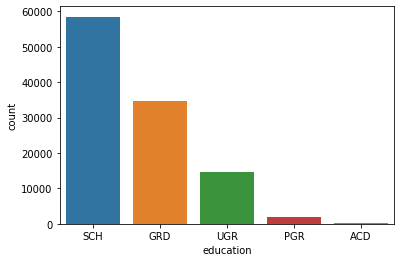

Категориальная переменная "home_address":
2    59591
1    48688
3     1869
Name: home_address, dtype: int64


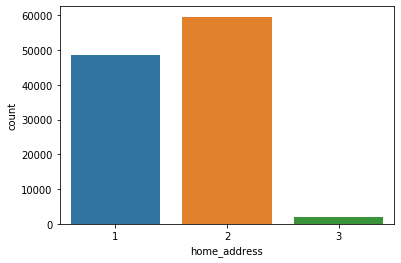

Категориальная переменная "work_address":
3    67113
2    30761
1    12274
Name: work_address, dtype: int64


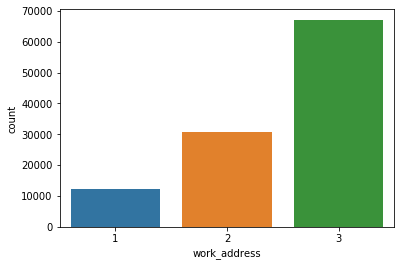

Категориальная переменная "sna":
1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64


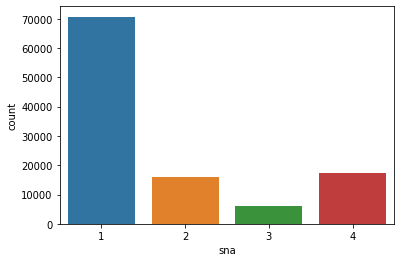

Категориальная переменная "first_time":
3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64


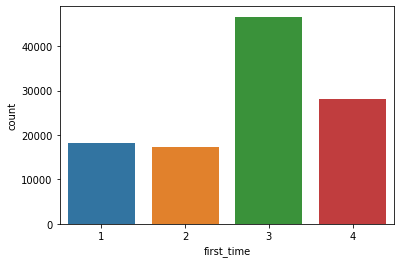

Категориальная переменная "gen_theory":
3    61285
4    26763
2    22092
1        8
Name: gen_theory, dtype: int64


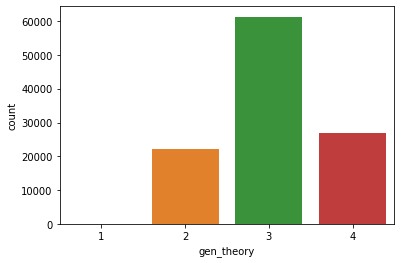

In [35]:
# работаем по циклу с категориальными переменными
for col in cat_cols:
    # выводим название переменной
    print('Категориальная переменная "{a}":'.format(a=col))
    # выводим уникальные значения и их количество
    print(data[col].value_counts())
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data)
    plt.show()

В каждом графике категориальной переменной данные распределенны неравномерно, где то присуствует один ярко выраженный признак, где то большинство признаков преобладают над другими, но так как все признаки разбиты на категории выбросами их считать нельзя

## 4.4 Бинарные переменные

Бинарная переменная "sex":
F    61836
M    48312
Name: sex, dtype: int64


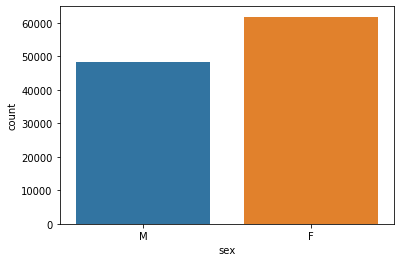

Бинарная переменная "car":
N    74290
Y    35858
Name: car, dtype: int64


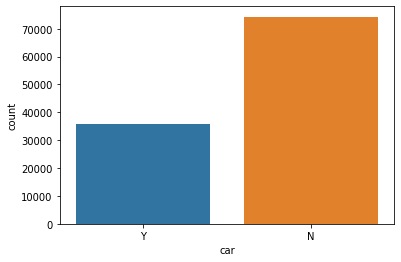

Бинарная переменная "car_type":
N    89140
Y    21008
Name: car_type, dtype: int64


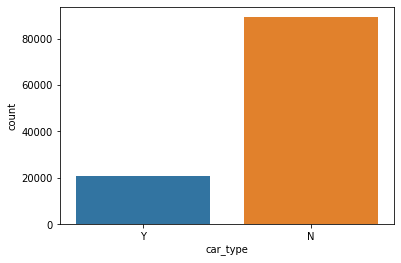

Бинарная переменная "good_work":
0    91917
1    18231
Name: good_work, dtype: int64


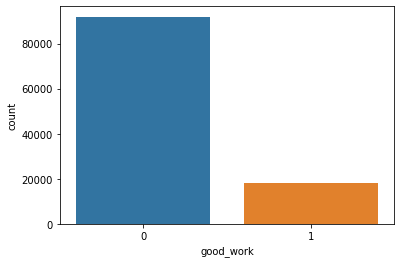

Бинарная переменная "foreign_passport":
N    93721
Y    16427
Name: foreign_passport, dtype: int64


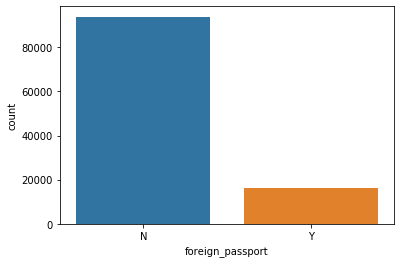

In [37]:
# работаем по циклу с переменными
for col in bin_cols:
    # выводим название переменной
    print('Бинарная переменная "{a}":'.format(a=col))
    # выводим уникальные значения и их количество
    print(data[col].value_counts())
    # выводим распределение заемщиков по признакам
    plt.figure()
    sns.countplot(x=col, data=data)
    plt.show()

В переменной пол данные распределенны примерно равномерно, но в остальных преобладает один из факторов.

## 4.5 Числовые переменные

Числовая переменная "age":
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64


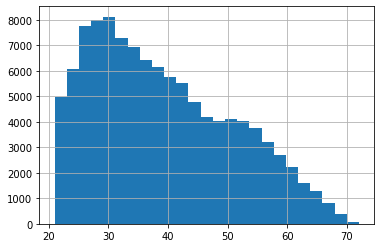

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


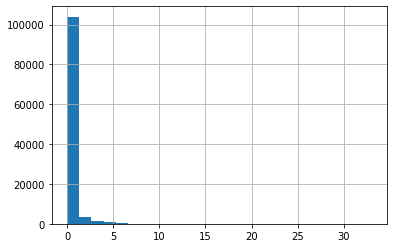

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


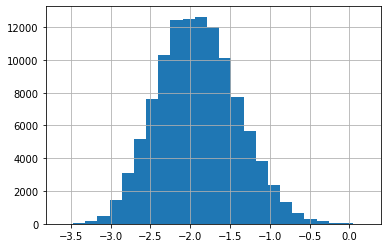

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


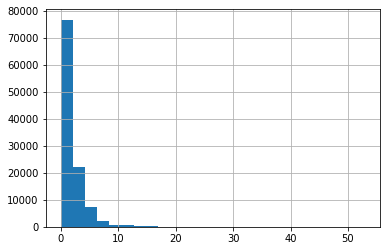

Числовая переменная "region_rating":
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


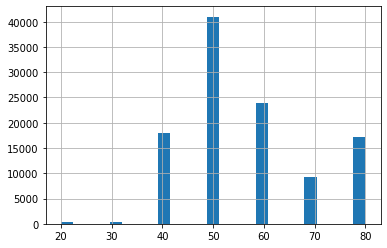

Числовая переменная "income":
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


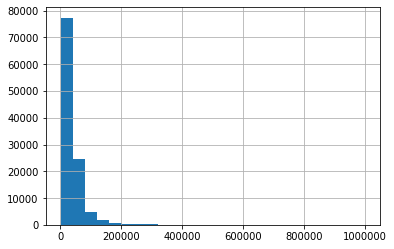

Числовая переменная "num_app":
count    110148.000000
mean       1002.761267
std         234.959584
min          56.000000
25%         848.000000
50%        1071.000000
75%        1173.000000
max        1491.000000
Name: num_app, dtype: float64


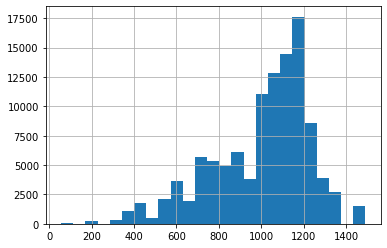

Числовая переменная "birth_year":
count    110148.000000
mean       1974.750590
std          11.518063
min        1942.000000
25%        1966.000000
50%        1977.000000
75%        1984.000000
max        1993.000000
Name: birth_year, dtype: float64


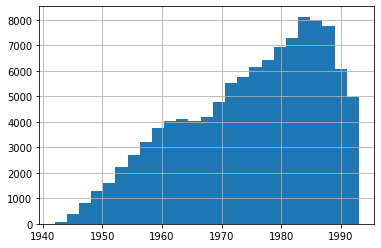

Числовая переменная "resp_cli":
count    110148.000000
mean          1.731797
std           2.279933
min         -31.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: resp_cli, dtype: float64


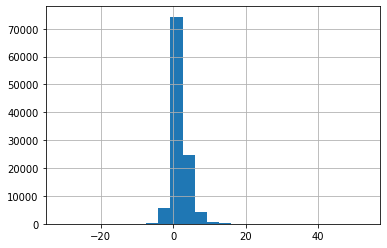

In [39]:
# работаем по циклу с переменными
for col in num_cols:
    # выводим название переменной
    print('Числовая переменная "{a}":'.format(a=col))
    print(data[col].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=25)
    plt.show()

На графиках видно что у некоторых переменных есть смещение данных поэтому посмотрим как будут распределяться данные если взять квадратный корень

Числовая переменная "age":
count    110148.000000
mean         39.249410
std          11.518063
min          21.000000
25%          30.000000
50%          37.000000
75%          48.000000
max          72.000000
Name: age, dtype: float64


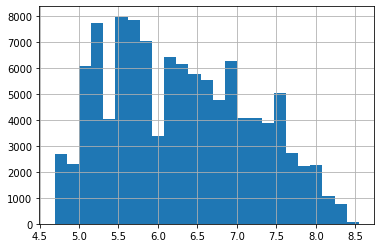

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


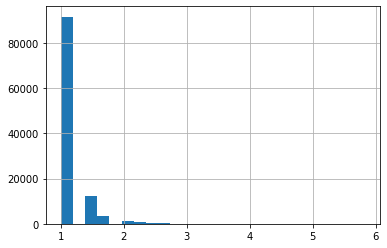

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


C:\Users\Mudriy\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


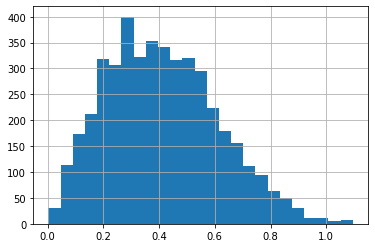

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          2.005002
std           2.266926
min           0.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: bki_request_cnt, dtype: float64


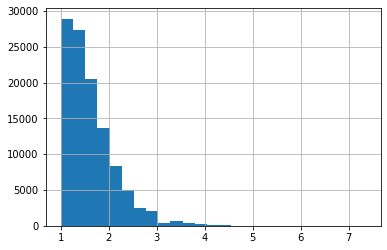

Числовая переменная "region_rating":
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


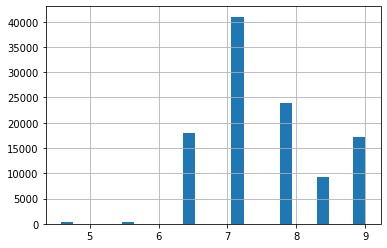

Числовая переменная "income":
count     110148.000000
mean       41012.648537
std        45399.735051
min         1000.000000
25%        20000.000000
50%        30000.000000
75%        48000.000000
max      1000000.000000
Name: income, dtype: float64


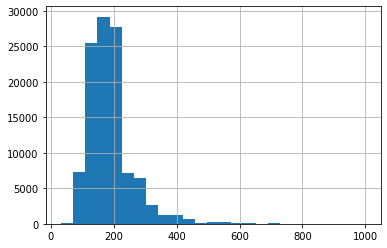

Числовая переменная "num_app":
count    110148.000000
mean       1002.761267
std         234.959584
min          56.000000
25%         848.000000
50%        1071.000000
75%        1173.000000
max        1491.000000
Name: num_app, dtype: float64


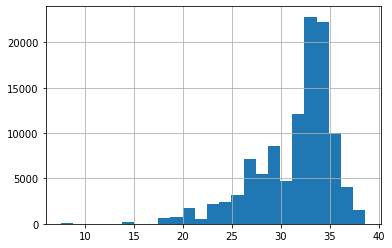

Числовая переменная "birth_year":
count    110148.000000
mean       1974.750590
std          11.518063
min        1942.000000
25%        1966.000000
50%        1977.000000
75%        1984.000000
max        1993.000000
Name: birth_year, dtype: float64


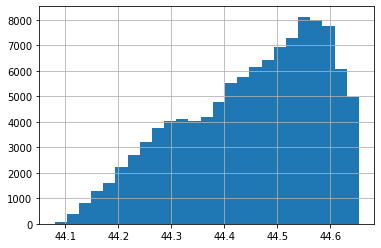

Числовая переменная "resp_cli":
count    110148.000000
mean          1.731797
std           2.279933
min         -31.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: resp_cli, dtype: float64


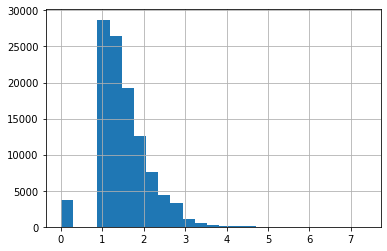

In [40]:
# посмотрим на распределение квадратных корней из переменных
for col in num_cols:
    # выводим название переменной
    print('Числовая переменная "{a}":'.format(a=col))
    print(data[col].describe())
    # выводим распределение заемщиков по признакам
    np.sqrt(data[col]+1).hist(bins=25)
    plt.show()

На графиках видно что age, bki_request_cnt, income и birth_year распределенны с смещением поэтому применим к данным переменным логарифмирование. Остальные данные распределенны более менее нормально.

In [41]:
data['age'] = np.log(data['age']+1)
data['bki_request_cnt'] = np.log(data['bki_request_cnt']+1)
data['income'] = np.log(data['income']+1)
data['birth_year'] = np.log(data['birth_year']+1)

Числовая переменная "age":
count    110148.000000
mean          3.654546
std           0.285054
min           3.091042
25%           3.433987
50%           3.637586
75%           3.891820
max           4.290459
Name: age, dtype: float64


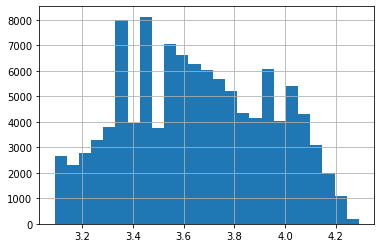

Числовая переменная "decline_app_cnt":
count    110148.000000
mean          0.273205
std           0.799099
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          33.000000
Name: decline_app_cnt, dtype: float64


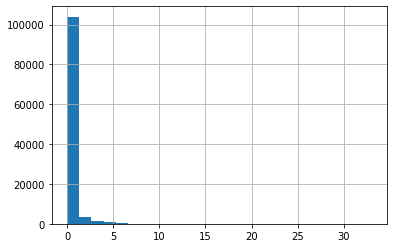

Числовая переменная "score_bki":
count    110148.000000
mean         -1.904535
std           0.499397
min          -3.624586
25%          -2.260434
50%          -1.920823
75%          -1.567888
max           0.199773
Name: score_bki, dtype: float64


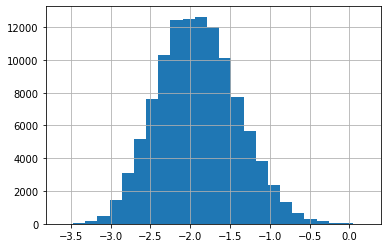

Числовая переменная "bki_request_cnt":
count    110148.000000
mean          0.878752
std           0.658667
min           0.000000
25%           0.000000
50%           0.693147
75%           1.386294
max           3.988984
Name: bki_request_cnt, dtype: float64


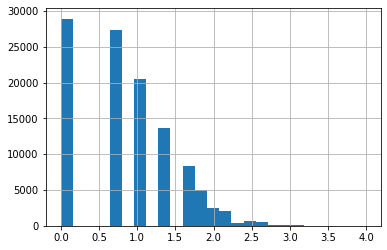

Числовая переменная "region_rating":
count    110148.000000
mean         56.751189
std          13.065923
min          20.000000
25%          50.000000
50%          50.000000
75%          60.000000
max          80.000000
Name: region_rating, dtype: float64


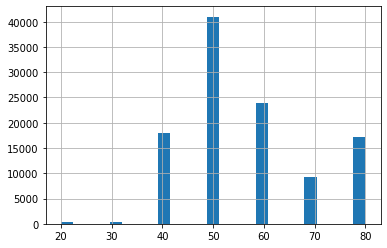

Числовая переменная "income":
count    110148.000000
mean         10.345792
std           0.696636
min           6.908755
25%           9.903538
50%          10.308986
75%          10.778977
max          13.815512
Name: income, dtype: float64


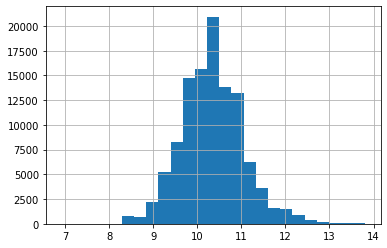

Числовая переменная "num_app":
count    110148.000000
mean       1002.761267
std         234.959584
min          56.000000
25%         848.000000
50%        1071.000000
75%        1173.000000
max        1491.000000
Name: num_app, dtype: float64


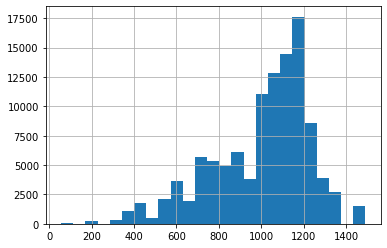

Числовая переменная "birth_year":
count    110148.000000
mean          7.588687
std           0.005838
min           7.571988
25%           7.584265
50%           7.589842
75%           7.593374
max           7.597898
Name: birth_year, dtype: float64


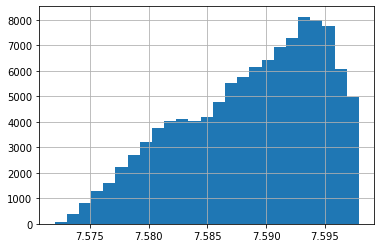

Числовая переменная "resp_cli":
count    110148.000000
mean          1.731797
std           2.279933
min         -31.000000
25%           0.000000
50%           1.000000
75%           3.000000
max          53.000000
Name: resp_cli, dtype: float64


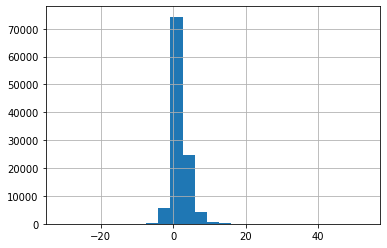

In [42]:
# посмотрим на распределения получишихся переменных
for col in num_cols:
    # выводим название переменной
    print('Числовая переменная "{a}":'.format(a=col))
    print(data[col].describe())
    # выводим распределение заемщиков по признакам
    data[col].hist(bins=25)
    plt.show()

Делая выводы по графикам числовых переменных больших выбросов там нет, данные в пределах графика возможны.

# 5. Оценка значимости переменных

## 5.1 Преобразования бинарных переменных

In [44]:
# преобразуем даные с помощью метода fit класса LabelEncoder
label_encoder = LabelEncoder()
for col in bin_cols:
    data[col] = pd.Series(label_encoder.fit_transform(data[col]))

In [45]:
# проверим преобразования
data[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,0,0,1
3,0,0,0,0,0
4,1,0,0,1,1


## 5.2 Преобразования категориальных переменных

In [48]:
# преобразуем переменную education
label_encoder = LabelEncoder()
data['education'] = pd.Series(label_encoder.fit_transform(data['education']))

In [47]:
# проверим преобразования
data[cat_cols]

,education,home_address,work_address,sna,first_time,gen_theory
0,3,1,2,4,1,2
1,3,2,3,4,1,2
2,3,1,2,1,4,4
3,3,2,3,1,3,2
4,1,2,3,1,4,3
...,...,...,...,...,...,...
110143,3,2,3,4,1,3
110144,1,1,2,1,4,2
110145,1,1,2,4,2,3
110146,4,2,3,1,1,4


## 5.3 Оценка корреляций

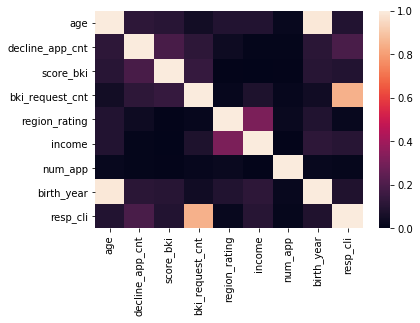

In [49]:
# оценим корреляцию Пирсона для числовых переменных
sns.heatmap(data[num_cols].corr().abs(), vmin=0, vmax=1)

Вывод: переменные age и birth_year имеют значение корреляции 1, поэтому в живых оставим age

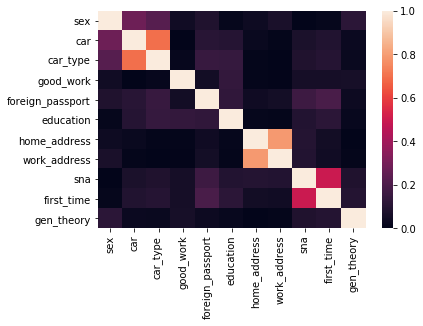

In [50]:
# оценим корреляцию Спирмана для остальных групп переменных
sns.heatmap(data[bin_cols + cat_cols].corr(method='spearman').abs(), vmin=0, vmax=1)

Вывод: корреляций равной 1 нет, оставим в живых все что есть

In [52]:
num_cols = ['age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt',
            'region_rating', 'income', 'num_app', 'resp_cli']

## 5.4 Оценка значимости числовых переменных

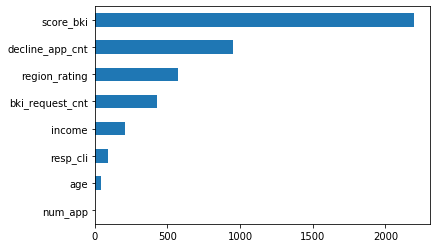

In [53]:
# проверяем значимость переменных
imp_num = pd.Series(f_classif(data[num_cols],
                              data['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

## 5.5 Оценка значимости категориальных и бинарных переменных

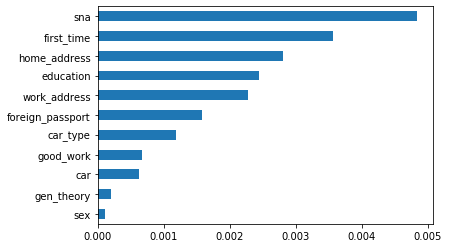

In [54]:
# проверяем значимость переменных
imp_cat = Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'],
                                     discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

# 6. Строим модель

In [56]:
# выделяем тренировочный датасет из датасета data
data_train = data[data['dataset'] == 1]
data_train = data_train.drop(['client_id', 'app_date', 'dataset'], axis=1)

In [58]:
data_train.head()

,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,...,work_address,income,sna,first_time,foreign_passport,default,num_app,birth_year,gen_theory,resp_cli
0,3,1,4.143135,1,1,0,0,-2.008753,0.693147,50,...,2,9.798183,4,1,0,0,794,7.577122,2,1
1,3,0,4.094345,0,0,0,0,-1.532276,1.386294,50,...,3,9.852247,4,1,0,0,1110,7.578657,2,3
2,3,1,3.258097,1,0,2,0,-1.408142,0.693147,80,...,2,10.308986,1,4,1,0,794,7.595890,4,-1
3,3,0,3.988984,0,0,0,0,-2.057471,1.098612,50,...,3,9.210440,1,3,0,0,1060,7.581720,2,2
4,1,1,3.891820,0,0,0,1,-1.244723,0.693147,60,...,3,10.308986,1,4,1,0,981,7.584265,3,1


In [59]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73799 entries, 0 to 73798
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   education         73799 non-null  int64  
 1   sex               73799 non-null  int32  
 2   age               73799 non-null  float64
 3   car               73799 non-null  int32  
 4   car_type          73799 non-null  int32  
 5   decline_app_cnt   73799 non-null  int64  
 6   good_work         73799 non-null  int64  
 7   score_bki         73799 non-null  float64
 8   bki_request_cnt   73799 non-null  float64
 9   region_rating     73799 non-null  int64  
 10  home_address      73799 non-null  int64  
 11  work_address      73799 non-null  int64  
 12  income            73799 non-null  float64
 13  sna               73799 non-null  int64  
 14  first_time        73799 non-null  int64  
 15  foreign_passport  73799 non-null  int32  
 16  default           73799 non-null  int64 

In [60]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_train_cat = OneHotEncoder(sparse=False).fit_transform(
    data_train[cat_cols].values)

In [61]:
# проверяем
data_train_cat

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 1., 0.]])

In [62]:
# стандартизируем числовые переменные
data_train_num = StandardScaler().fit_transform(data_train[num_cols].values)

In [63]:
# проверяем
data_train_num

array([[ 1.71113664, -0.34285766, -0.2087987 , ..., -0.78501579,
        -0.88946377, -0.31917215],
       [ 1.5399884 , -0.34285766,  0.74754461, ..., -0.70752611,
         0.45490047,  0.56180124],
       [-1.39343857,  2.14387966,  0.99669566, ..., -0.05288771,
        -0.88946377, -1.20014554],
       ...,
       [-0.66507223, -0.34285766,  0.78696739, ...,  0.5282444 ,
        -0.03860032,  1.00228793],
       [-0.89146325, -0.34285766,  0.85380611, ..., -1.25140899,
        -2.36571184,  0.56180124],
       [-0.35072683, -0.34285766,  0.28102087, ..., -0.31419734,
         0.24218461,  0.12131454]])

In [64]:
# объединяем категориальные, бинарные, числовые признаки
X = np.hstack([data_train_num, data_train[bin_cols].values, data_train_cat])
y = data_train['default'].values

In [65]:
# Разобьем данные для обучения и тестирования
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [66]:
# строим модель
model = LogisticRegression()
model.fit(X_train, y_train)

C:\Users\Mudriy\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

# 7. Оценка качества модели

## 7.1 ROC-анализ

In [67]:
# считаем метрики обучающей (X_train, y_train) выборки
y_train_probs = model.predict_proba(X_train)
y_train_probs = y_train_probs[:, 1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [68]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = model.predict_proba(X_test)
y_test_probs = y_test_probs[:, 1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

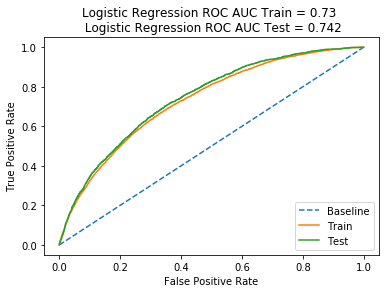

In [72]:
# строим графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a=roc_auc_train.round(3), b=roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

Вывод: метрика ROC AUC для обучающей и тестовоый выборок близка. Посмотрим, можно ли найти более оптимальные параметры для модели.

# 8. Поиск оптимальных значений гиперпараметров

In [75]:
# импорт библиотеки
from sklearn.model_selection import GridSearchCV

In [76]:
# ищем оптимальные значения гиперпараметров
model = LogisticRegression()
param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr']} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
for param_name in best_parameters:
        print(param_name, best_parameters[param_name], '\n')

C 1.0 

class_weight balanced 

dual False 

fit_intercept True 

intercept_scaling 1 

l1_ratio None 

max_iter 100 

multi_class auto 

n_jobs None 

penalty none 

random_state None 

solver newton-cg 

tol 0.0001 

verbose 0 

warm_start False 



## 8.1 Строим модель с подобранными гиперпарметрами

In [80]:
# строим модель
new_model = LogisticRegression(random_state=None,
                               C=1.0,
                               class_weight='balanced',
                               dual=False,
                               fit_intercept=True,
                               intercept_scaling=1,
                               l1_ratio=None,
                               max_iter=100,
                               multi_class='auto',
                               n_jobs=None,
                               penalty='none',
                               solver='newton-cg',
                               tol=0.0001,
                               verbose=0,
                               warm_start=False)
new_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='none', random_state=None, solver='newton-cg',
                   tol=0.0001, verbose=0, warm_start=False)

In [81]:
# считаем метрики обучающещей (X_train, y_train) выборки
y_train_probs = new_model.predict_proba(X_train)
y_train_probs = y_train_probs[:,1]
fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_train_probs)
roc_auc_train = roc_auc_score(y_train, y_train_probs)

In [82]:
# считаем метрики тестовой (X_test, y_test) выборки
y_test_probs = new_model.predict_proba(X_test)
y_test_probs = y_test_probs[:,1]
fpr_test, tpr_test, threshold_test = roc_curve(y_test, y_test_probs)
roc_auc_test = roc_auc_score(y_test, y_test_probs)

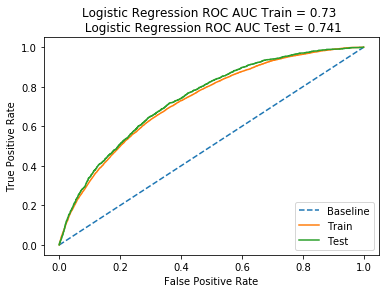

In [83]:
# строи графики метрик
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr_train, tpr_train, label = 'Train')
plt.plot(fpr_test, tpr_test, label = 'Test')
plt.title('Logistic Regression ROC AUC Train = {a} \n Logistic Regression ROC AUC Test = {b}'
          .format(a = roc_auc_train.round(3), b = roc_auc_test.round(3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Вывод: незнаю что я сделал, но новая модель с подобранными гиперпараметрами стала чуточку хуже, поэтому я буду использовать старую модель

# 9. Определяем значение дефолта клиентов

In [86]:
# выделяем тестовый датасет из датасета data
data_test = data[data['dataset'] == 0]
data_test = data_test.drop(['client_id', 'app_date', 'dataset'], axis=1)

In [87]:
# преобразуем категориальные переменные методом One-Hot Encoding
data_test_cat = OneHotEncoder(sparse=False).fit_transform(
    data_test[cat_cols].values)

In [88]:
# проверяем
data_test_cat

array([[0., 1., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 1., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [89]:
# стандартизируем числовые переменные
data_test_num = StandardScaler().fit_transform(data_test[num_cols].values)

In [90]:
# проверяем
data_test_num

array([[-0.88333898, -0.33995109, -0.73288746, ...,  0.68282058,
        -0.99730532,  0.54516402],
       [ 0.12606863,  6.00146439,  0.79551047, ..., -2.63253397,
         0.35300684, -2.06417195],
       [ 0.97850869, -0.33995109,  0.42413578, ..., -0.05272498,
        -1.33807811, -0.32461463],
       ...,
       [-0.65688874,  2.1966151 ,  1.92005304, ...,  0.9453502 ,
        -1.19324967, -1.19439329],
       [-1.12541848,  0.92833201,  1.31888606, ..., -0.05272498,
        -2.78210279, -0.32461463],
       [ 0.0372345 , -0.33995109,  0.79042787, ..., -1.05077617,
         1.4818167 ,  0.1102747 ]])

In [91]:
# объединяем категориальные, бинарные, числовые признаки 
X = np.hstack([data_test_num, data_test[bin_cols].values, data_test_cat])

In [93]:
# делаем расчет
y = model.predict_proba(X)
y = y[:,1]

In [95]:
# создаем новый датасет
submit = pd.DataFrame(test.client_id)

In [96]:
# включаем в датасет парсчитанные значения переменной default
submit['default'] = y

In [97]:
# выгружаем получившийся датасет в файл
submit.to_csv('submission.csv', index=False)